In [19]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import exposure, filters, measure, morphology, segmentation, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I43.09

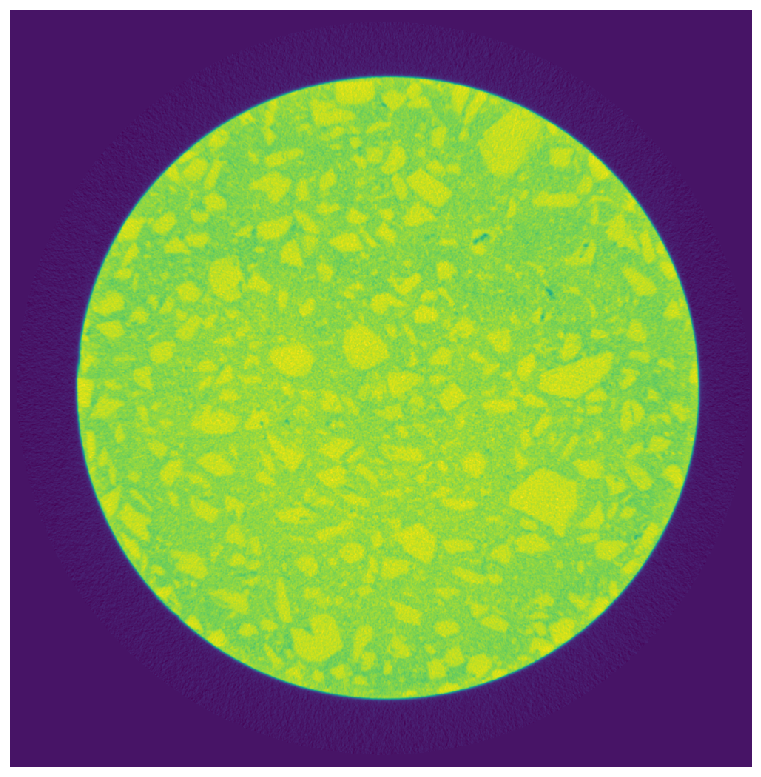

In [2]:
img_path = (
    r'C:\Users\cgusb\Research\mhe-analysis\data\I43\bin-2-tiffs\0506.tiff')
img = iio.imread(img_path)
fig, ax = view.images(img)

Generating histogram...


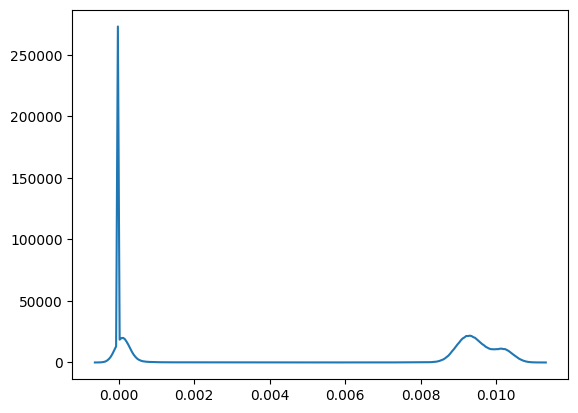

In [18]:
fig, ax = view.histogram(img)

Calculating Multi Otsu thresholds...
[0.00464154 0.00960682]


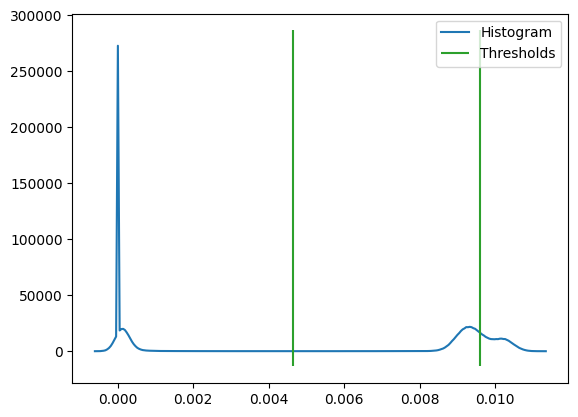

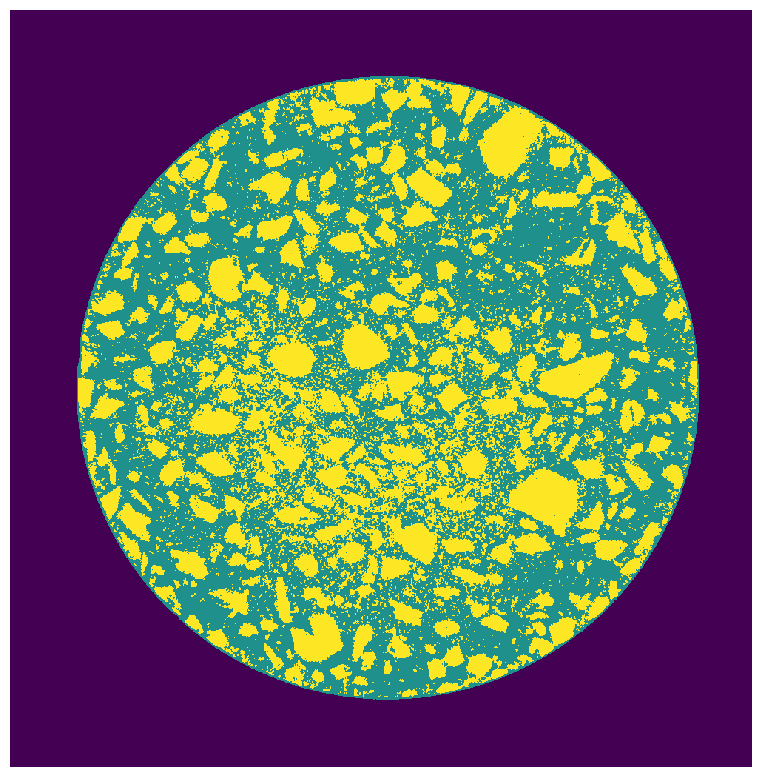

In [25]:
img_med = filters.median(img)
thresh_vals, fig, ax = segment.threshold_multi_otsu(
    img, nclasses=3, return_fig_ax=True)
print(thresh_vals)
img_semantic = np.zeros_like(img, dtype=np.uint8)
for i, val in enumerate(thresh_vals):
    img_semantic[img > val] = int((i + 1))
fig, ax = view.images(img_semantic)

Calculating Multi Otsu thresholds...
[0.00464154 0.00960682]


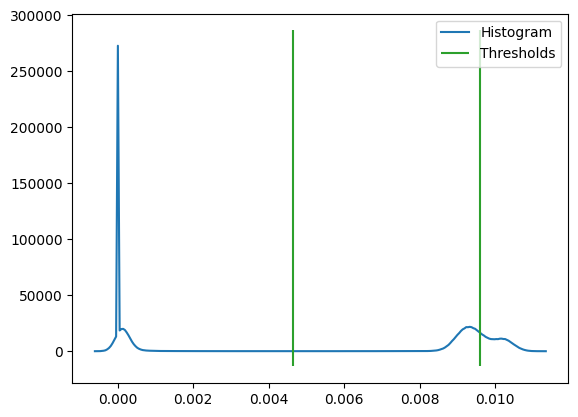

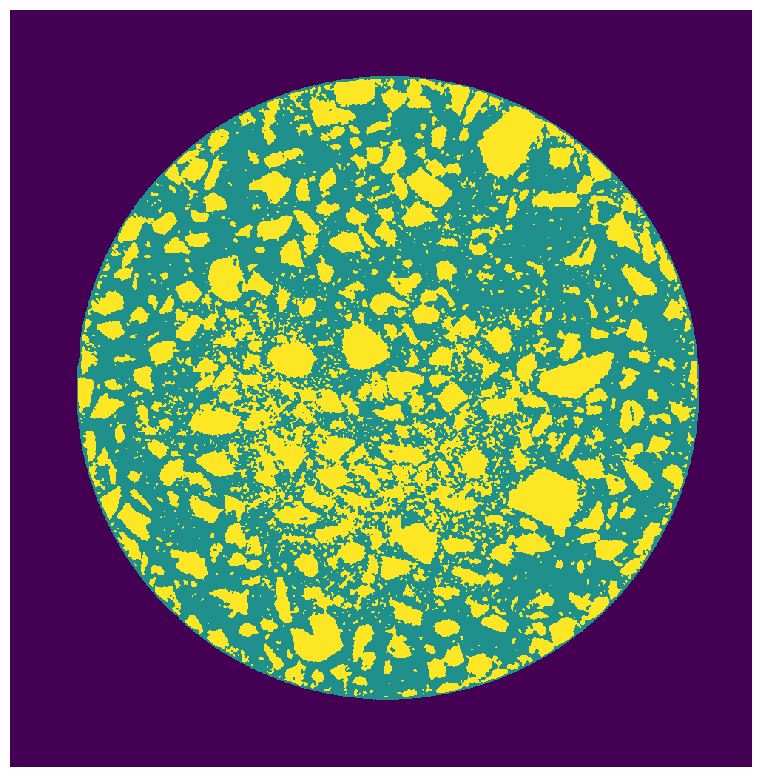

In [24]:
img_med = filters.median(img)
thresh_vals, fig, ax = segment.threshold_multi_otsu(
    img, nclasses=3, return_fig_ax=True)
print(thresh_vals)
med_semantic = np.zeros_like(img, dtype=np.uint8)
for i, val in enumerate(thresh_vals):
    med_semantic[img_med > val] = int((i + 1))
fig, ax = view.images(med_semantic)

(<Figure size 750x382.851 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

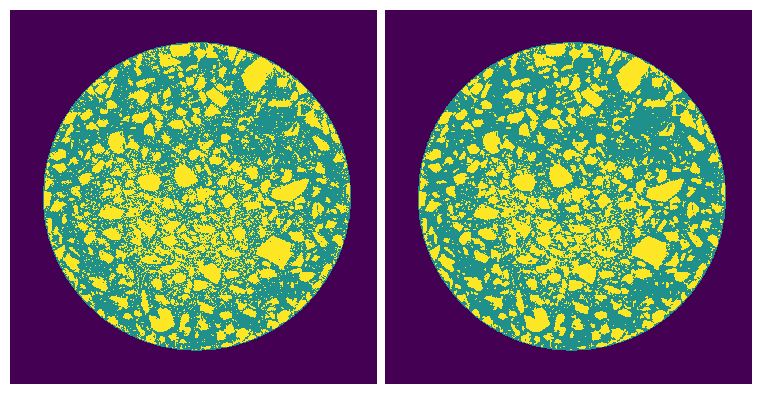

In [27]:
view.images([img_semantic, med_semantic])

### Equalize hist

Calculating Multi Otsu thresholds...
Calculating Multi Otsu thresholds...
Calculating Multi Otsu thresholds...
Calculating Multi Otsu thresholds...


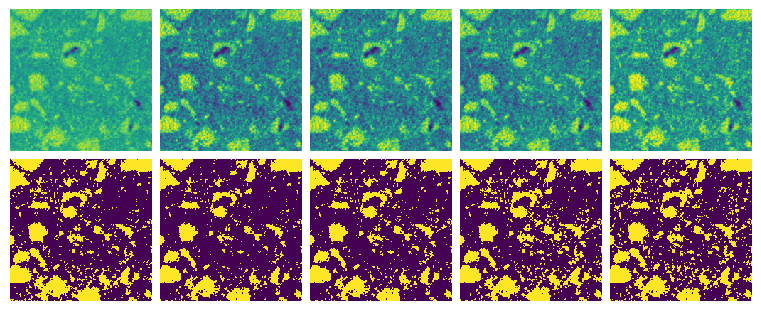

In [48]:
%matplotlib inline
# %matplotlib qt
eqs = {}
for denom in [4, 8, 16, 32]:
    eqs[denom] = exposure.equalize_adapthist(
        img, kernel_size=img.shape[0]//denom)
eq_sems = {}
for denom, eq in eqs.items():
    thresh_vals = segment.threshold_multi_otsu(eq, nclasses=3)
    eq_sems[denom] = np.zeros_like(img, dtype=np.uint8)
    for i, val in enumerate(thresh_vals):
        eq_sems[denom][eq > val] = int((i + 1))
view_imgs = [img, *eqs.values(), img_semantic, *eq_sems.values()]
view_range = [250, 450, 550, 750]
fig, ax = view.images(
    [i[view_range[0]:view_range[1], view_range[2]:view_range[3]] for i in view_imgs],
    imgs_per_row=len(eqs.keys())+1)